### Import the required modules

In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.resnet import preprocess_input 

# models 
from keras.applications.resnet import ResNet50
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from tqdm import tqdm

### Loading the data

In [2]:
data_path = 'data'

flowers = []
with os.scandir(data_path) as files:
    for file in files:
        if file.name.endswith('.png'):
            img_path = os.path.join(data_path, file.name)
            flowers.append(img_path)

### Data Preprocessing

Process the image to the required size for ResNet50 model.

In [3]:
def image_preprocessing(file):
    img = load_img(file, target_size=(224,224))
    img = np.array(img)
    reshaped_img = img.reshape(1,224,224,3)
    x = preprocess_input(reshaped_img)
    return x

### Model

In [4]:
model = ResNet50()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

### Feature extraction

We can pass our image through the predict method to get our feature vector.

In [5]:
def extract_features(image, model):
    img = image_preprocessing(image)
    features = model.predict(img, use_multiprocessing=True)
    return features

Now we can extract the features from all of the images and store the features in a dictionary with filename as the keys.

In [6]:
all_images = {}

for flower in tqdm(flowers):
    feat = extract_features(flower,model)
    all_images[flower] = feat

100%|██████████| 210/210 [00:27<00:00,  7.70it/s]


Get a list of the filenames and a list of just the features

In [7]:
filenames = np.array(list(all_images.keys()))
feat = np.array(list(all_images.values()))
feat.shape

(210, 1, 2048)

Reshape so that there are 210 samples of 2048 vectors

In [8]:
feat = feat.reshape(-1,2048)
feat.shape

(210, 2048)

Get the unique labels (from the flower_labels.csv)

In [9]:
df = pd.read_csv(f'{data_path}/flower_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

### Dimensionality Reduction (PCA)

For reducing the dimensionality by keeping as much information as possible, we use PCA.

In [10]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [11]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 2048
Components after PCA: 100


### KMeans clustering

Kmeans algorithm will allow us to group our feature vectors into k clusters (in this research we have 10).

In [12]:
kmeans = KMeans(n_clusters=len(unique_labels), n_jobs=-1, random_state=22)
kmeans.fit(x)

/home/nastia/Desktop/education/image_clusterization/venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(n_clusters=10, n_jobs=-1, random_state=22)

View the predicted labels

In [13]:
kmeans.labels_

array([4, 2, 7, 1, 3, 3, 4, 1, 3, 2, 5, 4, 3, 6, 8, 1, 4, 1, 5, 3, 4, 0,
       5, 6, 9, 7, 7, 5, 1, 6, 8, 2, 8, 3, 3, 8, 3, 3, 6, 5, 7, 7, 7, 1,
       7, 0, 9, 3, 5, 1, 1, 1, 1, 8, 9, 2, 4, 1, 1, 4, 8, 1, 2, 2, 8, 5,
       2, 1, 4, 1, 0, 0, 6, 7, 4, 4, 6, 3, 4, 2, 1, 4, 7, 6, 0, 4, 4, 3,
       1, 6, 3, 4, 4, 1, 3, 3, 2, 4, 3, 6, 4, 6, 1, 4, 1, 7, 1, 8, 3, 2,
       5, 1, 6, 7, 3, 2, 4, 2, 0, 6, 4, 7, 5, 8, 7, 0, 4, 2, 8, 6, 8, 4,
       4, 6, 1, 0, 1, 7, 3, 1, 3, 1, 5, 6, 7, 8, 3, 1, 2, 2, 7, 7, 3, 8,
       3, 6, 1, 1, 4, 2, 7, 7, 8, 4, 0, 1, 5, 2, 6, 1, 1, 1, 3, 5, 3, 9,
       8, 4, 8, 7, 4, 8, 7, 4, 1, 6, 8, 8, 3, 4, 4, 1, 2, 4, 5, 8, 5, 6,
       1, 5, 0, 3, 2, 4, 3, 2, 4, 2, 8, 2], dtype=int32)

Now we can group the images into their clusters.

In [14]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

### Visualization of clusters

In [15]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 30:
        files = files[:29]
        
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Cluster 1

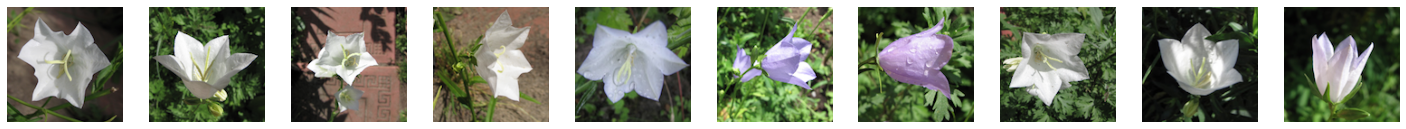

In [16]:
view_cluster(0)

Cluster 2

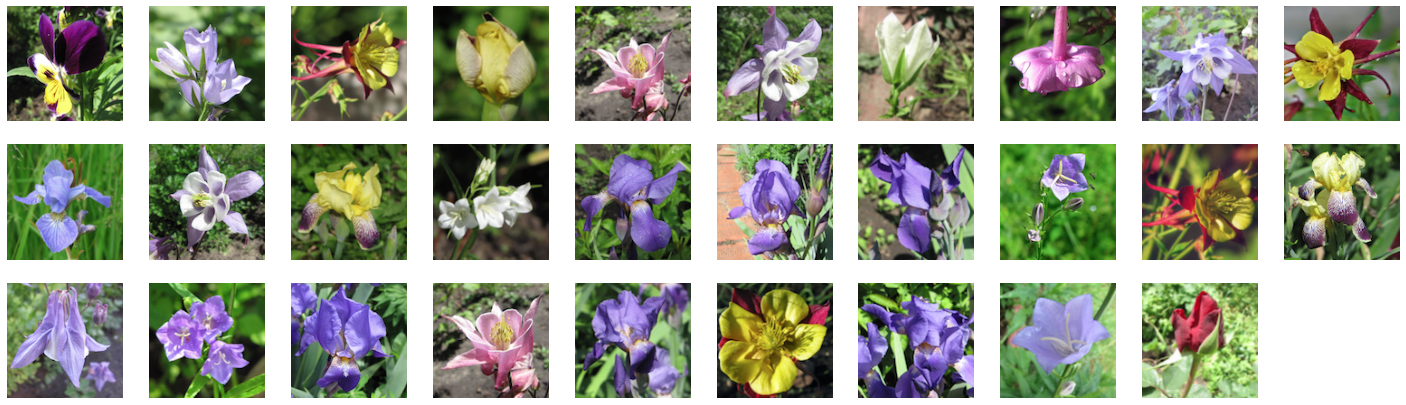

In [17]:
view_cluster(1)

Cluster 3

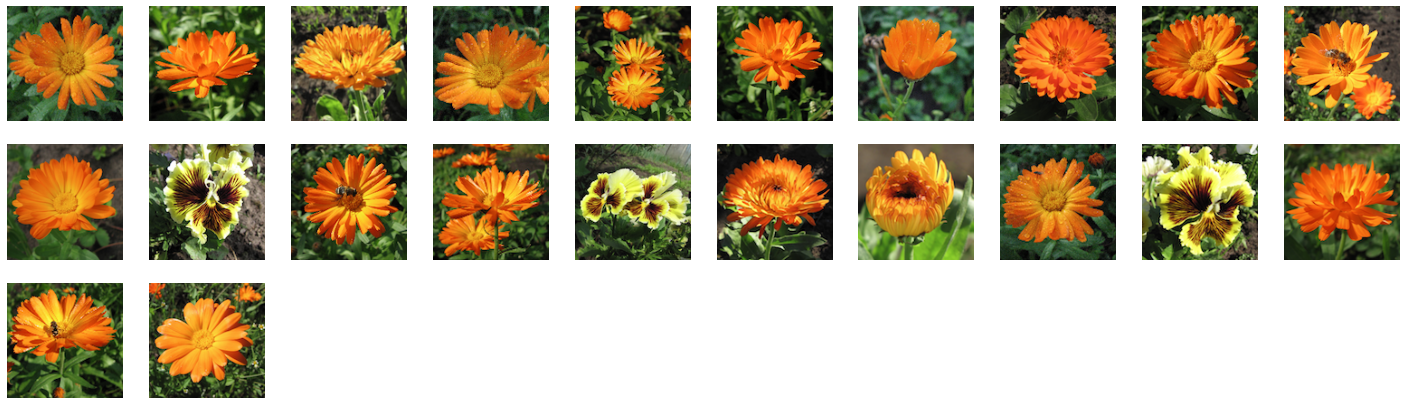

In [18]:
view_cluster(2)

Cluster 4

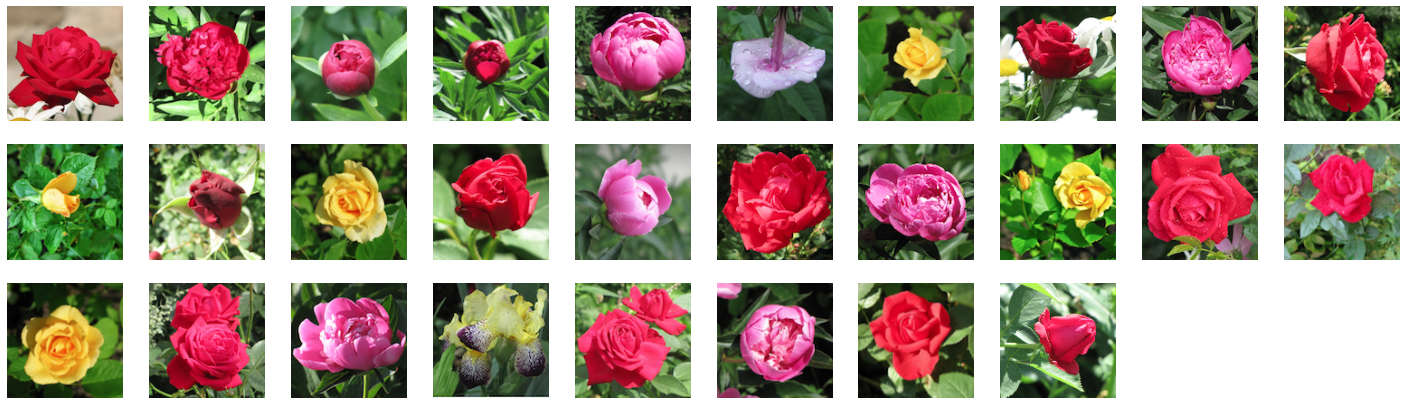

In [19]:
view_cluster(3)

Cluster 5

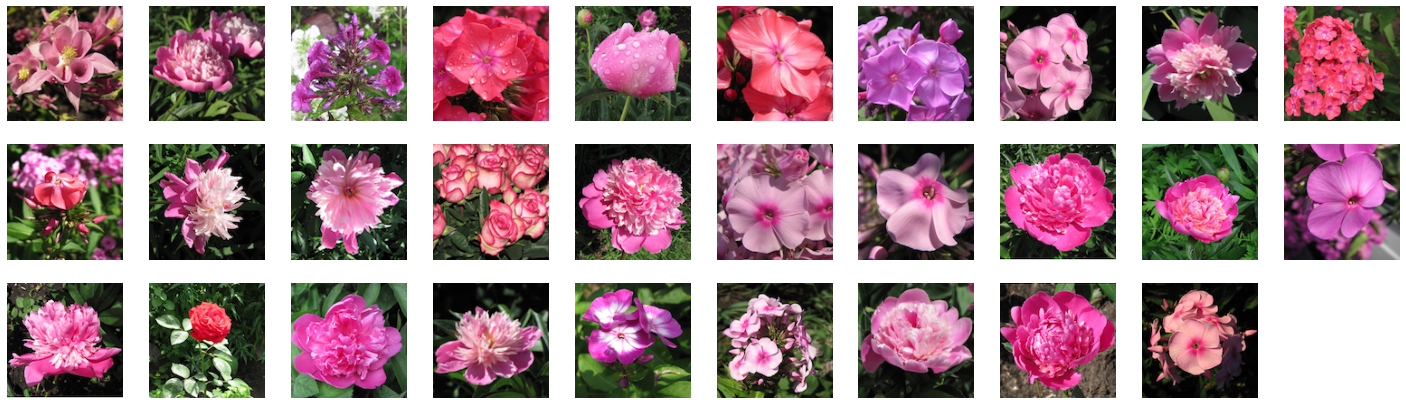

In [20]:
view_cluster(4)

Cluster 6

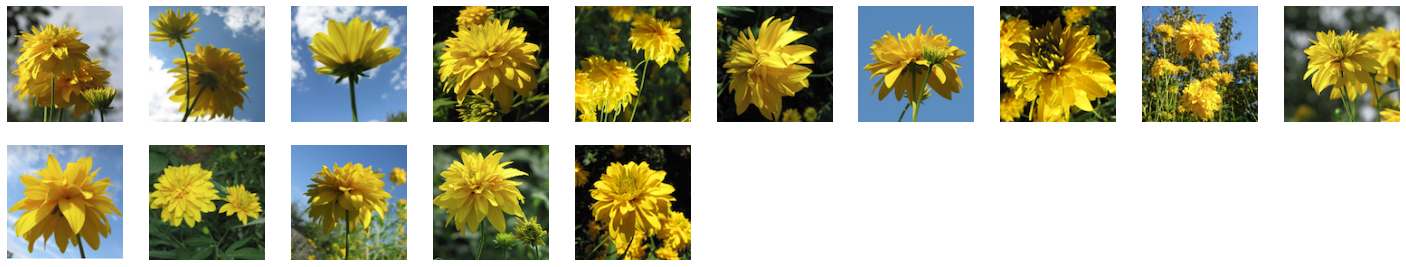

In [21]:
view_cluster(5)

Cluster 7

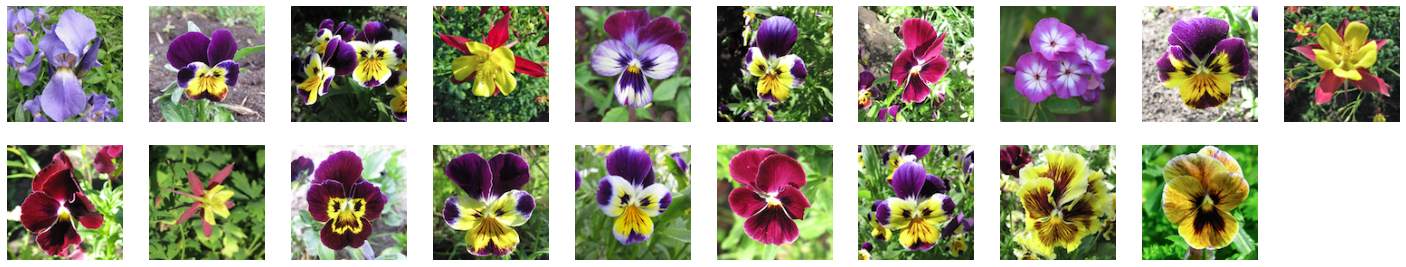

In [22]:
view_cluster(6)

Cluster 8

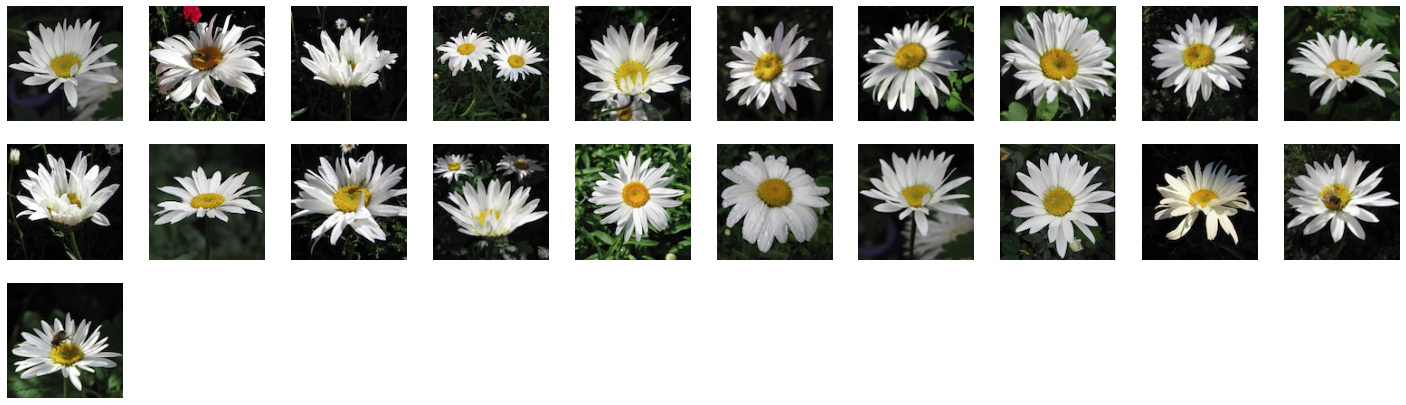

In [23]:
view_cluster(7)

Cluster 9

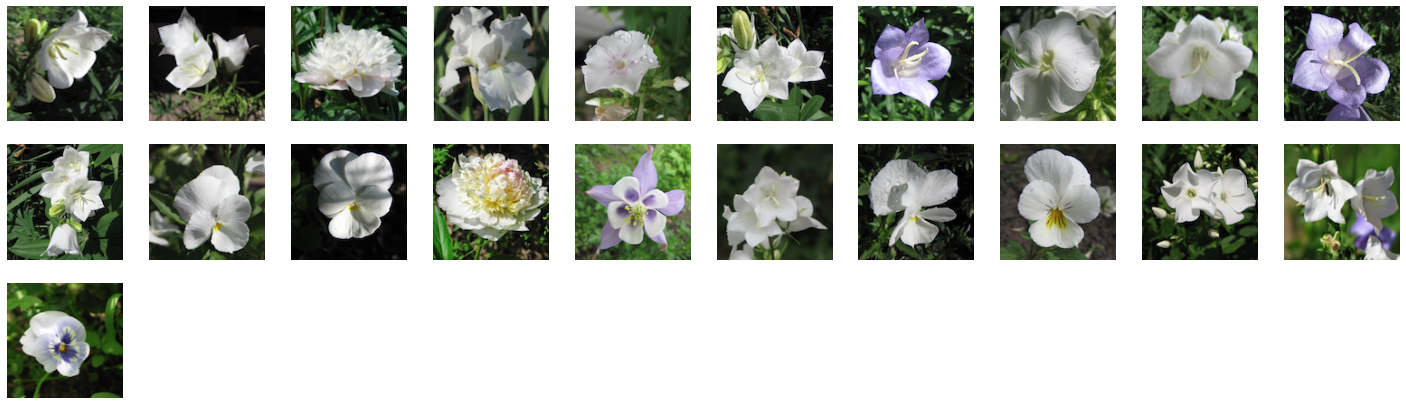

In [24]:
view_cluster(8)

Cluster 10

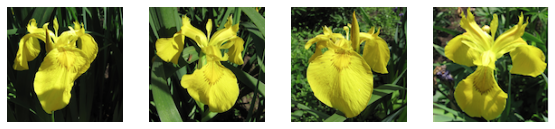

In [25]:
view_cluster(9)